# Las Vegas 评论文本情感分析 EDA

### 该 Notebook 对应的博客[链接](XXX)

### 该 Notebook 针对 Las Vegas 中的一家名为 Mon Ami Gabi 的商店进行探索性数据分析（Exploratory Data Analysis, EDA）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 加载数据

商店 Mon Ami Gabi 的 db_id 可以直接在数据库中查询得到：
![](images/sentiment/mon_ami_gabi_db_record.png)

## 1.1 过滤出对商店 Mon Ami Gabi 的评论 db_id

In [2]:
yelp_lv_rvs = pd.read_csv('../../dataset/las_vegas/review/las_vegas_review_with_db_id.csv')

In [3]:
yelp_lv_rvs[:5]

,db_id,review_id,user_db_id,business_db_id,stars,year
0,3,---3OXpexMp0oAg77xWfYA,999269,92729,5,2012
1,6,---94vtJ_5o_nikEs6hUjg,313272,122971,5,2014
2,8,---D6-P4MpS86LYldBfX7w,735101,160943,4,2016
3,20,---WDP9kwKyVQiw9GTgNmQ,1045600,12131,1,2014
4,22,---zHMCae68gIbSbtXxD5w,971613,15470,4,2015


In [4]:
mag_rv_db_ids = yelp_lv_rvs[yelp_lv_rvs.business_db_id==14826]['db_id'].values

In [5]:
len(mag_rv_db_ids)

7362

## 1.2 过滤出商店 Mon Ami Gabi 的评论文本内容（已预处理过）

In [6]:
yelp_lv_rts = pd.read_csv('../../dataset/las_vegas/review/las_vegas_review_text_preprocessed_with_db_id.csv')

In [7]:
len(yelp_lv_rts)

1604044

In [8]:
mag_rts = yelp_lv_rts[yelp_lv_rts.review_db_id.isin(mag_rv_db_ids)]

In [9]:
len(mag_rts)

7359

In [10]:
mag_rts[:5]

,review_db_id,text_words
16,46,romantic spot lv great people watch nice menu ...
889,2821,great food incredible breakfast french toast m...
942,3020,brenda daughter take u mon ami gabi sunday bre...
1084,3479,thank perry check visit also thank breakfast s...
1201,3884,birthday seat outside weather comfortable file...


## 1.3 将评论文本内容拆分成列表

In [11]:
mag_rv_text_words = [words.split(' ') for words in mag_rts.text_words]

In [12]:
len(mag_rv_text_words)

7359

In [13]:
mag_rv_text_words[:2]

[['romantic',
  'spot',
  'lv',
  'great',
  'people',
  'watch',
  'nice',
  'menu',
  'good',
  'food',
  'service',
  'must',
  'come',
  'la',
  'vega'],
 ['great',
  'food',
  'incredible',
  'breakfast',
  'french',
  'toast',
  'must',
  'great',
  'location',
  'vive',
  'always',
  'pack',
  'excellent',
  'service']]

# 2. 商店 Mon Ami Gabi EDA

## 2.1 前 10 个最正面和最负面的评价词

这里我们采用的 Python 库 Affin 是一个基于**词**的情感分析库，下边是其[官方介绍](https://github.com/fnielsen/afinn)：

> AFINN sentiment analysis in Python: Wordlist-based approach for sentiment analysis.

In [14]:
from afinn import Afinn

In [15]:
# 过滤掉重复词
unique_rv_words = set()
for words in mag_rv_text_words:
    unique_rv_words |= set(words)
len(unique_rv_words)

13174

In [16]:
af = Afinn()
sentiment_scores = pd.Series() # 这里用 pandas Series 主要是方便下边找 TOP 10 和绘图
for word in unique_rv_words:
    sentiment_scores = sentiment_scores.append(pd.Series([af.score(word)], index=[word]))

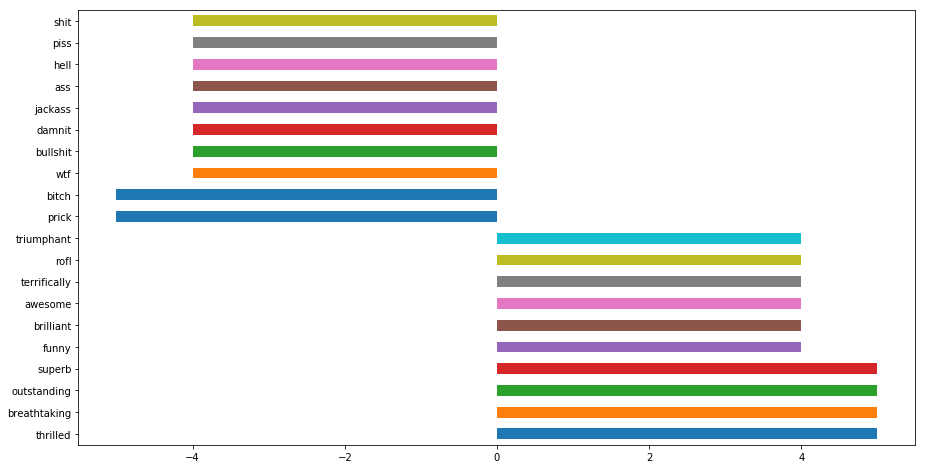

In [17]:
# 绘制前 10 个最正面和最负面的评价词情感值
# 由结果可以看出，用 Affin 库得到的结果还是比较准确的
sentiment_scores.nlargest(10).\
    append(sentiment_scores.nsmallest(10)).\
        plot(kind='barh', figsize=(15, 8))

## 2.2 计算每一个评论的情感值

每一个评论的情感值为该评论中所有词的情感值的平均值

In [18]:
mag_rts = mag_rts.assign(sentiment=[np.mean([af.score(word) for word in words]) for words in mag_rv_text_words])

In [19]:
mag_rts[['review_db_id', 'sentiment']][:10]

,review_db_id,sentiment
16,46,0.600000
889,2821,0.642857
942,3020,0.200758
1084,3479,0.562500
1201,3884,0.333333
1441,4621,0.428571
1597,5177,0.057143
1603,5196,0.253968
1655,5350,0.166667
1758,5688,0.526316


## 2.3 找出前 10 个最正面和最负面的评论文本

In [20]:
yelp_ori_rvs = pd.read_csv('../../dataset/all/review.csv')

In [21]:
pd.set_option('display.max_colwidth', -1)

In [22]:
# Top 10 positive reviews
for review_db_id in mag_rts.nlargest(10, 'sentiment')['review_db_id']:
    review_id = yelp_lv_rvs[yelp_lv_rvs.db_id==review_db_id]['review_id'].values[0]
    print review_db_id, '# ', yelp_ori_rvs[yelp_ori_rvs.review_id==review_id]['text'].values[0], '\n'

4839142 #  Loved the chicken =] very good 

334944 #  Great food and awesome views 

1074898 #  Amazing   awesome   lovely  So nice to find a gem - had a lovely breakfast here.  Very reasonably priced, excellent food. 

3365047 #  Very good, excellent service , Steak Frite is outstanding . 
Mussels are  very good .
Excellent location 

1134350 #  Delicious seafood. Great service. Awesome cocktails! 

2668526 #  Best nice dinner deal in Vegas! Yummy, affordable, and with great portions. 

786037 #  Very good salmon
Nice ambience
Nice view 
Good service 

3277705 #  Great ambience! Good food. Pleasant experience. 

4912818 #  We had an awesome breakfast and will definitely come back for other meals.  Delicious, creative, superb service and wonderful ambience! 

1758893 #  Wonderful food, great service and the soups are always good! 



In [23]:
# Top 10 negative reviews
for review_db_id in mag_rts.nsmallest(10, 'sentiment')['review_db_id']:
    review_id = yelp_lv_rvs[yelp_lv_rvs.db_id==review_db_id]['review_id'].values[0]
    print review_id, '# ', yelp_ori_rvs[yelp_ori_rvs.review_id==review_id]['text'].values[0], '\n'

MtHh5xldXg6p7IDs5KjbJg #  The food was decent. Servicer was terrible. They charge me for two bottles I stole ..... Wtf . 

-JwlVaN6hdbqI3ztHkA2Xg #  Do the patio and the bloody Mary bar. 

1mvrW4noBECcjegA7-jtcg #  Very bad 
Had nothing to do with French food. Except for few French words on the menus maybe!!!
What a shame... 

QnMcPoJHUBUQzbGxZEaAaA #  This is the most horrible restaurant in the strip. Really bad service , the wine was warm .. The waiter was super rude .. And the ladies on the entrance when we reported what happens they just stay quite. Horrible. Food also expensive and really bad 

faFB96PZTpBIuxLYIzVV_g #  Worst food I ever had. Complained to the staff, they were rude. Called the manager over, he was even more rude and basically didn't believe me that the food was bad. Needless to say, I ended up in urgent care and was sick all night long. Never coming back here again. The only thing French about this restaurant is the attitude of its staff. 

JA8IOiAnDn7xKjCUrGvRYA 